# A groundwater model for Schoonhoven

In this notebook we build a transient model for the area around Schoonhoven. Surface water is added to the model using a winter and a summer stage using the drain package. For the river Lek, we build a river package with a fixed stage of NAP+0.0 m.

In [1]:
import os
import flopy
import matplotlib
import matplotlib.pyplot as plt
import nlmod
import numpy as np
import xarray as xr
import pandas as pd
import hydropandas as hpd
import geopandas as gpd
from nlmod.plot import DatasetCrossSection
from shapely.geometry import LineString, Point
import warnings


In [2]:
print(f"nlmod version: {nlmod.__version__}")

nlmod.util.get_color_logger("INFO")

nlmod version: 0.6.2b


<RootLogger root (INFO)>

## Model settings
We define some model settings, like the name, the directory of the model files, the model extent and the time

In [3]:
model_name = "Schoonhoven"
model_ws = "schoonhoven"
figdir, cachedir = nlmod.util.get_model_dirs(model_ws)
extent = [116_500, 120_000, 439_000, 442_000]
time = pd.date_range("2020", "2023", freq="MS")  # monthly timestep


## Download data

### layer 'waterdeel' from bgt
As the source of the location of the surface water bodies we a GeoDataFrame we created in the the surface notebook. We then saved this data as a geosjon. We now read this data again.

In [4]:
fname_bgt = os.path.join(cachedir, "bgt.geojson")
if not os.path.isfile(fname_bgt):
    raise (
        Exception(
            f"{fname_bgt} not found. Please run notebook 02_surface_water.ipynb first"
        )
    )
bgt = gpd.read_file(fname_bgt)


#### Plot summer stage of surface water bodies
We can plot the summer stage. There are some surface water bodies without a summer-stage, because the 'bronhouder' is not a water board. The main one is the river Lek, but there are also some surface water bodies without a summer stage more north.

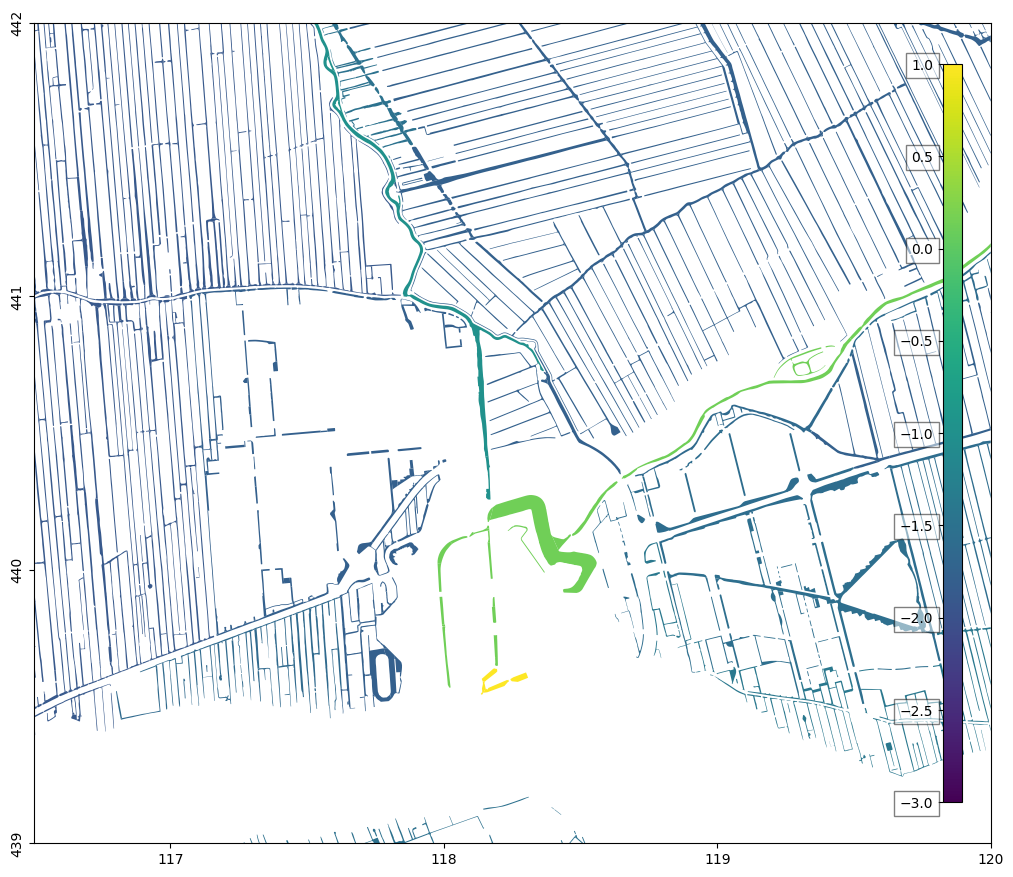

In [5]:
f, ax = nlmod.plot.get_map(extent)
norm = matplotlib.colors.Normalize(vmin=-3, vmax=1)
cmap = "viridis"
bgt.plot("summer_stage", ax=ax, norm=norm, cmap=cmap)
nlmod.plot.colorbar_inside(norm=norm, cmap=cmap);

If no information about the stage is available, a constant stage is set to the minimal height of the digital terrain model (AHN) near the surface water body. We can plot these values as well:

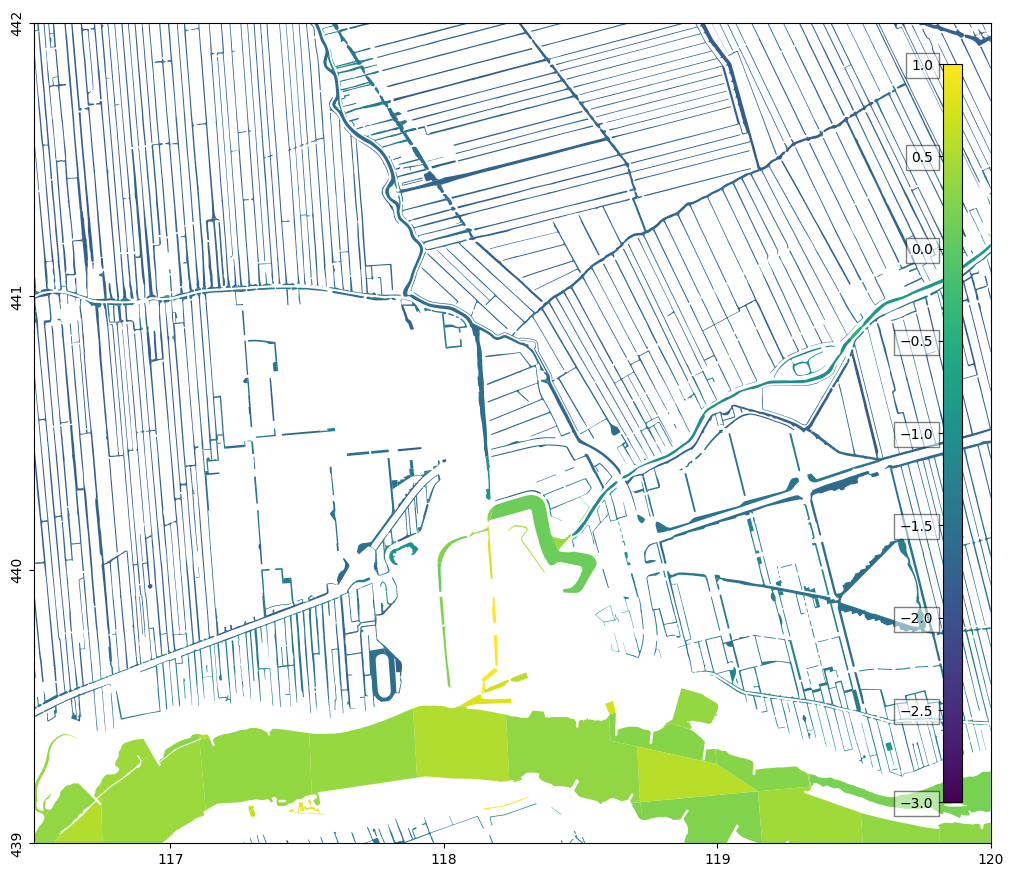

In [6]:
f, ax = nlmod.plot.get_map(extent)
bgt.plot("ahn_min", ax=ax, norm=norm, cmap=cmap)
nlmod.plot.colorbar_inside(norm=norm, cmap=cmap);

### REGIS
For the schematisation of the subsurface we use REGIS. Let's download this data for the required extent.

In [7]:
layer_model = nlmod.read.regis.get_combined_layer_models(
    extent,
    use_regis=True,
    use_geotop=False,
    cachedir=cachedir,
    cachename="layer_model.nc",
)
layer_model


INFO:nlmod.cache.decorator:using cached data -> layer_model.nc


<xarray.Dataset>
Dimensions:  (layer: 29, y: 30, x: 35)
Coordinates:
  * x        (x) float64 1.166e+05 1.166e+05 1.168e+05 ... 1.198e+05 1.2e+05
  * y        (y) float64 4.42e+05 4.418e+05 4.418e+05 ... 4.392e+05 4.39e+05
  * layer    (layer) object 'HLc' 'KRWYk1' 'KRz2' 'KRz3' ... 'OOz2' 'OOc' 'BRk1'
Data variables:
    top      (layer, y, x) float32 -1.28 -1.22 -1.25 ... -360.4 -360.4 -360.4
    botm     (layer, y, x) float32 -12.26 -12.11 -11.93 ... -592.3 -593.9 -595.5
    kh       (layer, y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    kv       (layer, y, x) float32 nan nan nan nan ... 0.002 0.002 0.002 0.002
Attributes: (12/40)
    references:                    https://www.dinoloket.nl/regis-ii-het-hydr...
    Conventions:                   CF-1.7
    creator_url:                   https://www.dinoloket.nl
    keywords_vocabulary:           NASA/GCMD Earth Science Keywords. Version 6.0
    acknowledgment:                https://www.dinoloket.nl
    project:                       REGIS v02r2
    ...                            ...
    geospatial_lon_resolution:     0.0014573401
    geospatial_vertical_min:       -1235.92
    geospatial_vertical_max:       322.75
    geospatial_vertical_units:     m-NAP
    geospatial_vertical_positive:  up
    extent:                        [116500 120000 439000 442000]

We then create a regular grid, add nessecary variables (eg idomain) and fill nan's. For example, REGIS does not contain infomration about the hydraulic conductivity of the first layer ('HLc'). These NaN's are replaced by a default hydraulic conductivity (kh) of 1 m/d. This probably is not a good representation of the conductivity, but at least the model will run.

In [8]:
ds = nlmod.to_model_ds(layer_model, model_name, model_ws, delr=100.0, delc=100.0)
ds


INFO:nlmod.dims.base.to_model_ds:resample layer model data to structured modelgrid
INFO:nlmod.dims.layers.get_kh_kv:kv and kh both undefined in layer HLc
INFO:nlmod.dims.layers._fill_var:Filling 7594 values in active cells of kh by multipying kv with an anisotropy of 10
INFO:nlmod.dims.layers._fill_var:Filling 16762 values in active cells of kv by dividing kh by an anisotropy of 10
INFO:nlmod.dims.layers._fill_var:Filling 1050 values in active cells of kh with a value of 1.0 m/day
INFO:nlmod.dims.layers._fill_var:Filling 1050 values in active cells of kv with a value of 0.1 m/day


<xarray.Dataset>
Dimensions:  (y: 30, x: 35, layer: 29)
Coordinates:
  * layer    (layer) object 'HLc' 'KRWYk1' 'KRz2' 'KRz3' ... 'OOz2' 'OOc' 'BRk1'
  * x        (x) float64 1.166e+05 1.166e+05 1.168e+05 ... 1.198e+05 1.2e+05
  * y        (y) float64 4.42e+05 4.418e+05 4.418e+05 ... 4.392e+05 4.39e+05
Data variables:
    top      (y, x) float32 -1.28 -1.22 -1.25 -1.25 ... -3.88 -4.05 -3.76 -4.21
    botm     (layer, y, x) float32 -12.26 -12.11 -11.93 ... -592.3 -593.9 -595.5
    kh       (layer, y, x) float32 1.0 1.0 1.0 1.0 1.0 ... 0.02 0.02 0.02 0.02
    kv       (layer, y, x) float32 0.1 0.1 0.1 0.1 ... 0.002 0.002 0.002 0.002
    area     (y, x) float64 1e+04 1e+04 1e+04 1e+04 ... 1e+04 1e+04 1e+04 1e+04
Attributes:
    extent:      [116500, 120000, 439000, 442000]
    gridtype:    structured
    delr:        100.0
    delc:        100.0
    model_name:  Schoonhoven
    mfversion:   mf6
    created_on:  20230828_13:59:19
    exe_name:    C:\Users\tombb\Python scripts\nlmod\nlmod\bin\mf6.exe
    model_ws:    schoonhoven
    figdir:      schoonhoven\figure
    cachedir:    schoonhoven\cache
    transport:   0

## Add grid refinement
With the refine method, we can add grid refinement. The model will then use the disv-package instead of the dis-package. We can also test if the disv-package gives the same results as the dis-package by not specifying refinement_features: ds = nlmod.grid.refine(ds).

This notebook can be run with or without running the cell below.

In [9]:
refinement_features = [(bgt[bgt["bronhouder"] == "L0002"], 2)]
ds = nlmod.grid.refine(ds, refinement_features=refinement_features)


INFO:nlmod.dims.grid.refine:create vertex grid using gridgen


INFO:nlmod.dims.grid.ds_to_gridprops:resample model Dataset to vertex modelgrid


## Add information about time

In [10]:
ds = nlmod.time.set_ds_time(ds, time=time)


## Add knmi recharge to the model dataset

In [11]:
knmi_ds = nlmod.read.knmi.get_recharge(ds, cachedir=cachedir, cachename="recharge.nc")
ds.update(knmi_ds)


INFO:nlmod.cache.decorator:using cached data -> recharge.nc


<xarray.Dataset>
Dimensions:   (icell2d: 2769, layer: 29, iv: 2973, icv: 9, time: 37)
Coordinates:
  * layer     (layer) object 'HLc' 'KRWYk1' 'KRz2' ... 'OOz2' 'OOc' 'BRk1'
    x         (icell2d) float64 1.166e+05 1.166e+05 ... 1.2e+05 1.2e+05
    y         (icell2d) float64 4.42e+05 4.42e+05 4.42e+05 ... 4.39e+05 4.39e+05
  * time      (time) datetime64[ns] 2020-01-01 2020-02-01 ... 2023-01-01
Dimensions without coordinates: icell2d, iv, icv
Data variables:
    top       (icell2d) float32 -1.28 -1.22 -1.25 -1.25 ... -4.21 -4.21 -4.21
    botm      (layer, icell2d) float32 -12.26 -12.11 -11.93 ... -595.5 -595.5
    kh        (layer, icell2d) float32 1.0 1.0 1.0 1.0 ... 0.02 0.02 0.02 0.02
    kv        (layer, icell2d) float32 0.1 0.1 0.1 0.1 ... 0.002 0.002 0.002
    area      (icell2d) float32 1e+04 1e+04 1e+04 1e+04 ... 625.0 625.0 625.0
    xv        (iv) float64 1.165e+05 1.166e+05 1.166e+05 ... 1.2e+05 1.2e+05
    yv        (iv) float64 4.42e+05 4.42e+05 4.419e+05 ... 4.39e+05 4.39e+05
    icvert    (icell2d, icv) int32 0 1 2 3 0 -1 -1 ... 2971 2969 -1 -1 -1 -1
    recharge  (time, icell2d) float64 0.0006692 0.0006692 ... 0.003139 0.003139
Attributes:
    extent:      [116500, 120000, 439000, 442000]
    gridtype:    vertex
    delr:        100.0
    delc:        100.0
    model_name:  Schoonhoven
    mfversion:   mf6
    created_on:  20230828_13:59:19
    exe_name:    C:\Users\tombb\Python scripts\nlmod\nlmod\bin\mf6.exe
    model_ws:    schoonhoven
    figdir:      schoonhoven\figure
    cachedir:    schoonhoven\cache
    transport:   0

## Create a groundwater flow model
Using the data from the xarray Dataset ds we generate a groundwater flow model.

In [12]:
# create simulation
sim = nlmod.sim.sim(ds)

# create time discretisation
tdis = nlmod.sim.tdis(ds, sim)

# create ims
ims = nlmod.sim.ims(sim)

# create groundwater flow model
gwf = nlmod.gwf.gwf(ds, sim)

# Create discretization
dis = nlmod.gwf.dis(ds, gwf)

# create node property flow
npf = nlmod.gwf.npf(ds, gwf, save_flows=True)

# Create the initial conditions package
ic = nlmod.gwf.ic(ds, gwf, starting_head=0.0)

# Create the output control package
oc = nlmod.gwf.oc(ds, gwf)

# create storagee package
sto = nlmod.gwf.sto(ds, gwf)


INFO:nlmod.sim.sim.sim:creating mf6 SIM
INFO:nlmod.sim.sim.tdis:creating mf6 TDIS


INFO:nlmod.sim.sim.ims:creating mf6 IMS
INFO:nlmod.gwf.gwf.gwf:creating mf6 GWF
INFO:nlmod.gwf.gwf._dis:creating mf6 DIS
INFO:nlmod.gwf.gwf._disv:creating mf6 DISV
INFO:nlmod.gwf.gwf.npf:creating mf6 NPF
INFO:nlmod.gwf.gwf.ic:creating mf6 IC
INFO:nlmod.gwf.gwf.ic:adding 'starting_head' data array to ds
INFO:nlmod.gwf.gwf.oc:creating mf6 OC
INFO:nlmod.gwf.gwf.sto:creating mf6 STO


## Process surface water
We cut the surface water bodies with the grid, set a default resistance of 1 day, and seperate the large river 'Lek' form the other surface water bodies.

In [13]:
bed_resistance = 1.0

mg = nlmod.grid.modelgrid_from_ds(ds)
gi = flopy.utils.GridIntersect(mg, method="vertex")
bgt_grid = nlmod.grid.gdf_to_grid(bgt, ix=gi).set_index("cellid")

bgt_grid["cond"] = bgt_grid.area / bed_resistance

# handle the lek as a river
mask = bgt_grid["bronhouder"] == "L0002"
lek = bgt_grid[mask]
bgt_grid = bgt_grid[~mask]

# handle grote gracht and oude haven to model as a lake
ids_grote_gracht = [
    "W0656.774b12049d9a4252bd61c4ea442b5158",
    "W0656.59ab56cf0b2d4f15894c24369f0748df",
]
ids_oude_haven = [
    "W0656.a6013e26cd9442de86eac2295eb0012b",
    "W0656.2053970c192b4fe48bba882842e53eb5",
    "W0656.540780b5c9944b51b53d8a98445b315a",
    "W0656.a7c39fcaabe149c3b9eb4823f76db024",
    "W0656.cb3c3a25de4141d18c573b561f02e84a",
]

mask = bgt_grid["identificatie"].isin(ids_grote_gracht) | bgt_grid[
    "identificatie"
].isin(ids_oude_haven)
lakes = bgt_grid[mask].copy()
lakes.loc[lakes["identificatie"].isin(ids_grote_gracht), "name"] = "grote gracht"
lakes.loc[lakes["identificatie"].isin(ids_oude_haven), "name"] = "oude haven"
bgt_grid = bgt_grid[~mask]


Intersecting with grid: 100%|██████████| 1466/1466 [00:09<00:00, 155.49it/s]


### Lek as river
Model the river Lek as a river with a fixed stage of 0.5 m NAP

In [14]:
lek["stage"] = 0.0
lek["rbot"] = -3.0
spd = nlmod.gwf.surface_water.build_spd(lek, "RIV", ds)
riv = flopy.mf6.ModflowGwfriv(gwf, stress_period_data={0: spd})


Building stress period data RIV: 100%|██████████| 1702/1702 [00:00<00:00, 3688.72it/s]


### Other surface water as drains
model the other surface water using the drain package, with a summer stage and a  winter stage

In [15]:
drn = nlmod.gwf.surface_water.gdf_to_seasonal_pkg(bgt_grid, gwf, ds)

INFO:nlmod.gwf.surface_water.gdf_to_seasonal_pkg:Filling 4151 NaN's in rbot using a water depth of 0.5 meter.


Building stress period data DRN: 100%|██████████| 4151/4151 [00:01<00:00, 4076.84it/s]


### Add lake

Model de "grote gracht" and "Oude Haven" as lakes. Let the grote gracht overflow in to de oude Haven.

In [16]:
# add specific properties to the lake gdf
lakes.loc[lakes["identificatie"].isin(ids_grote_gracht), "lakeno"] = 0
lakes.loc[lakes["identificatie"].isin(ids_oude_haven), "lakeno"] = 1

# add general properties to the lake gdf
lakes["elev"] = lakes["ahn_min"] - 0.5
summer_months = (4, 5, 6, 7, 8, 9)
if pd.to_datetime(ds.time.start).month in summer_months:
    lakes["strt"] = lakes["summer_stage"]
else:
    lakes["strt"] = lakes["winter_stage"]
lakes["clake"] = 100

# add inflow to Oude Haven
# ds['inflow_lake'] = xr.DataArray(100, dims=["time"], coords=dict(time=ds.time))
# lakes.loc[lakes['identificatie'].isin(ids_oude_haven), 'INFLOW'] = 'inflow_lake'

# add outlet to Oude Haven, water flows from Oude Haven to Grote Gracht.
lakes.loc[lakes["identificatie"].isin(ids_oude_haven), "lakeout"] = 0
lakes.loc[
    lakes["identificatie"].isin(ids_oude_haven), "outlet_invert"
] = 1.0  # overstort hoogte

# add lake to groundwaterflow model
nlmod.gwf.lake_from_gdf(gwf, lakes, ds, boundname_column="name")

package_name = lak_0
filename = Schoonhoven.lak
package_type = lak
model_or_simulation_package = model
model_name = Schoonhoven

Block options
--------------------
boundnames
{internal}
(True)

stage_filerecord
{internal}
(rec.array([('lak.hds',)],
          dtype=[('stagefile', 'O')]))

budget_filerecord
{internal}
(rec.array([('lak.bgt',)],
          dtype=[('budgetfile', 'O')]))

obs_filerecord
{internal}
(rec.array([('Schoonhoven.lak.obs',)],
          dtype=[('obs6_filename', 'O')]))

surfdep
{internal}
(0.05)

time_conversion
{internal}
(86400.0)

length_conversion
{internal}
(1.0)


Block dimensions
--------------------
nlakes
{internal}
(2)

noutlets
{internal}
(1)


Block packagedata
--------------------
packagedata
{internal}
(rec.array([(0.0, 0.04, 14, 'grote gracht'), (1.0, 0.04,  8, 'oude haven')],
          dtype=[('lakeno', 'O'), ('strt', '<f8'), ('nlakeconn', '<i4'), ('boundname', 'O')]))


Block connectiondata
--------------------
connectiondata
{internal}
(rec.array([

In [17]:
# create recharge package
rch = nlmod.gwf.rch(ds, gwf)


INFO:nlmod.gwf.gwf.rch:creating mf6 RCH


Building ts packages rch: 100%|██████████| 3/3 [00:00<00:00, 53.13it/s]


## Run the model

In [18]:
nlmod.sim.write_and_run(sim, ds)


INFO:nlmod.sim.sim.write_and_run:write model dataset to cache
INFO:nlmod.sim.sim.write_and_run:write modflow files to model workspace
writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims...
  writing model Schoonhoven...
    writing model name file...
    writing package disv...
    writing package npf...
    writing package ic...
    writing package oc...
    writing package sto...
    writing package riv_0...
INFORMATION: maxbound in ('gwf6', 'riv', 'dimensions') changed to 1702 based on size of stress_period_data
    writing package drn_0...
INFORMATION: maxbound in ('gwf6', 'drn', 'dimensions') changed to 8302 based on size of stress_period_data
    writing package obs_0...
    writing package ts_0...
    writing package lak_0...
    writing package obs_1...
    writing package rch...
    writing package ts_1...
    writing package ts_2...
    writing package ts_3...
INFO:nlmod.sim.sim.write_and_run:run model
Fl

## Post-processing
### Get the simulated head

In [19]:
head = nlmod.gwf.get_heads_da(ds)


### Plot the average head in the first layer on a map

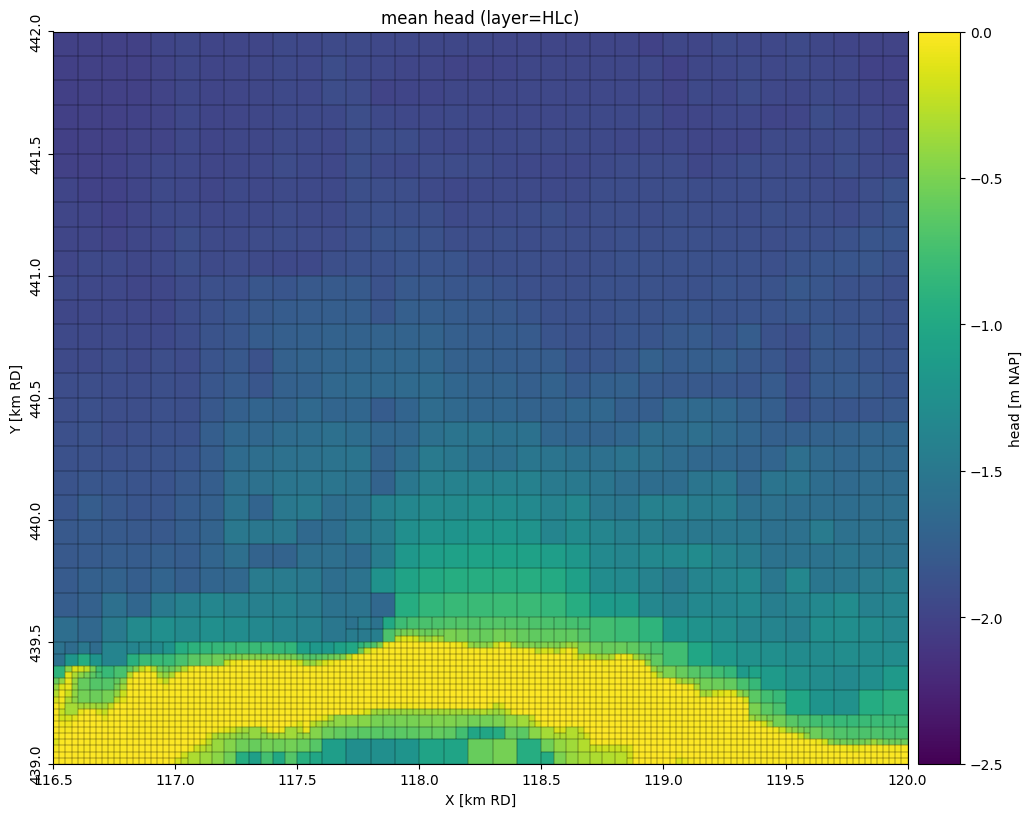

In [20]:
norm = matplotlib.colors.Normalize(-2.5, 0.0)


pc = nlmod.plot.map_array(
    head.sel(layer="HLc").mean("time"),
    ds,
    norm=norm,
    colorbar=True,
    colorbar_label="head [m NAP]",
    title="mean head",
)
bgt.plot(ax=ax, edgecolor="k", facecolor="none");

### Plot the average head in a cross-section, from north to south

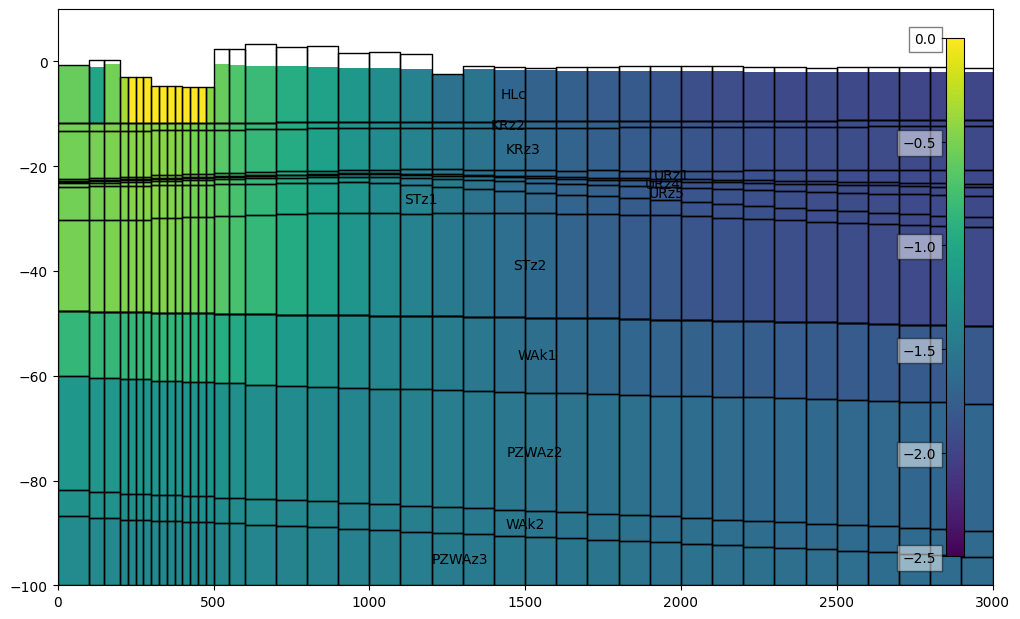

In [21]:
x = 118228.0
line = [(x, 439000), (x, 442000)]

f, ax = plt.subplots(figsize=(10, 6))
dcs = DatasetCrossSection(ds, line, ax=ax, zmin=-100.0, zmax=10.0)
pc = dcs.plot_array(head.mean("time"), norm=norm, head=head.mean("time"))

# add labels with layer names
cbar = nlmod.plot.colorbar_inside(pc)
dcs.plot_grid()
dcs.plot_layers(colors="none", min_label_area=1000)
f.tight_layout(pad=0.0)

### plot a time series at a certain location

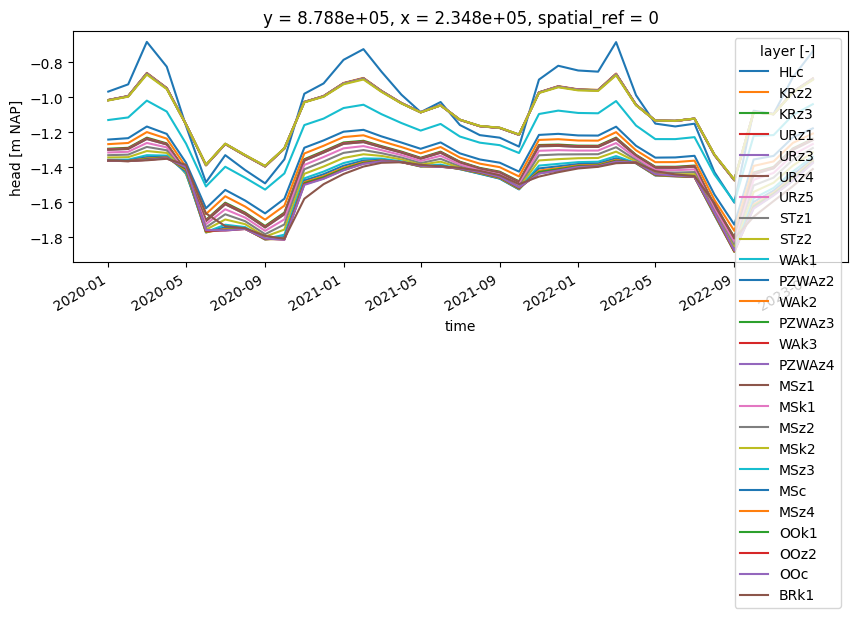

In [22]:
x = 118228
y = 439870
head_point = nlmod.gwf.get_head_at_point(head, x=x, y=y, ds=ds)
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
handles = head_point.plot.line(ax=ax, hue="layer")
ax.set_ylabel("head [m NAP]");

### plot the lake stages

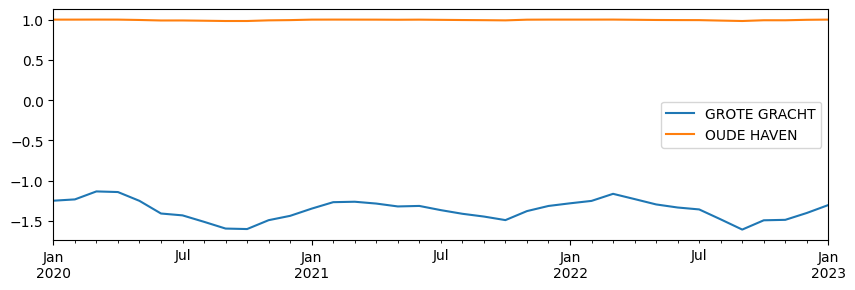

In [23]:
df = pd.read_csv(os.path.join(model_ws, "lak_STAGE.csv"), index_col=0)
df.index = ds.time.values
ax = df.plot(figsize=(10, 3))

### Plot some properties of the first layer
We can plot some properties of the first layer, called HLc. As REGIS does not contain data about hydraulic conductivities for this layer, default values of 1 m/d for kh and 0.1 m/d for hv are used, which can be seen in the graphs below.

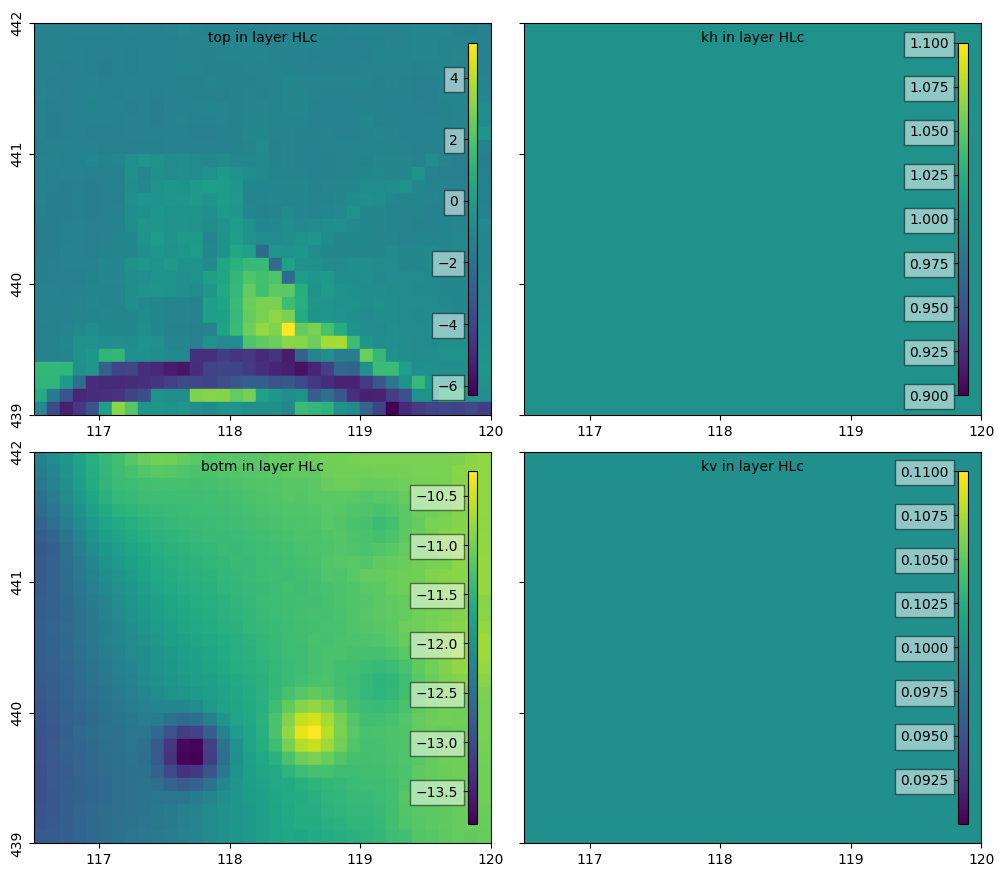

In [24]:
layer = "HLc"

f, axes = nlmod.plot.get_map(extent, nrows=2, ncols=2)
variables = ["top", "kh", "botm", "kv"]
for i, variable in enumerate(variables):
    ax = axes.ravel()[i]
    if variable == "top":
        if layer == ds.layer[0]:
            da = ds["top"]
        else:
            da = ds["botm"][np.where(ds.layer == layer)[0][0] - 1]
    else:
        da = ds[variable].sel(layer=layer)
    pc = nlmod.plot.data_array(da, ds=ds, ax=ax)
    nlmod.plot.colorbar_inside(pc, ax=ax)
    ax.text(
        0.5,
        0.98,
        f"{variable} in layer {layer}",
        ha="center",
        va="top",
        transform=ax.transAxes,
    )


In [36]:
ds

<xarray.Dataset>
Dimensions:        (icell2d: 2769, layer: 29, iv: 2973, icv: 9, time: 37)
Coordinates:
  * layer          (layer) object 'HLc' 'KRWYk1' 'KRz2' ... 'OOz2' 'OOc' 'BRk1'
    x              (icell2d) float64 1.166e+05 1.166e+05 ... 1.2e+05 1.2e+05
    y              (icell2d) float64 4.42e+05 4.42e+05 ... 4.39e+05 4.39e+05
  * time           (time) datetime64[ns] 2020-01-01 2020-02-01 ... 2023-01-01
Dimensions without coordinates: icell2d, iv, icv
Data variables:
    top            (icell2d) float32 -1.28 -1.22 -1.25 ... -4.21 -4.21 -4.21
    botm           (layer, icell2d) float32 -12.26 -12.11 ... -595.5 -595.5
    kh             (layer, icell2d) float32 1.0 1.0 1.0 1.0 ... 0.02 0.02 0.02
    kv             (layer, icell2d) float32 0.1 0.1 0.1 ... 0.002 0.002 0.002
    area           (icell2d) float32 1e+04 1e+04 1e+04 ... 625.0 625.0 625.0
    xv             (iv) float64 1.165e+05 1.166e+05 ... 1.2e+05 1.2e+05
    yv             (iv) float64 4.42e+05 4.42e+05 ... 4.39e+05 4.39e+05
    icvert         (icell2d, icv) int32 0 1 2 3 0 -1 ... 2971 2969 -1 -1 -1 -1
    recharge       (time, icell2d) float64 0.0006692 0.0006692 ... 0.003139
    starting_head  (layer, icell2d) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    rch_name       (icell2d) <U13 'rch_2' 'rch_2' 'rch_2' ... 'rch_2' 'rch_2'
Attributes: (12/15)
    extent:                            [116500, 120000, 439000, 442000]
    gridtype:                          vertex
    delr:                              100.0
    delc:                              100.0
    model_name:                        Schoonhoven
    mfversion:                         mf6
    ...                                ...
    figdir:                            schoonhoven\figure
    cachedir:                          schoonhoven\cache
    transport:                         0
    model_dataset_written_to_disk_on:  20230828_13:59:38
    model_data_written_to_disk_on:     20230828_13:59:44
    model_ran_on:                      20230828_14:00:10

In [29]:
scratch_path = r"C:\Users\tombb\OneDrive - PWN\NHFLO\Python\PWN Bergen model v2\scratch"

ds.to_netcdf(os.path.join(scratch_path, "ds_no_enc.nc"))

from nlmod.dims.attributes_encodings import get_encodings
encodings = get_encodings(ds, set_encoding_inplace=False, allowed_to_read_data_vars_for_minmax=True)
# print(encodings)

# ds.dtypes
# del encodings["rch_name"]
ds.to_netcdf(os.path.join(scratch_path, "ds_enc.nc"), encoding=encodings)

ds.dtypes

Frozen({'top': dtype('float32'), 'botm': dtype('float32'), 'kh': dtype('float32'), 'kv': dtype('float32'), 'area': dtype('float32'), 'xv': dtype('float64'), 'yv': dtype('float64'), 'icvert': dtype('int32'), 'recharge': dtype('float64'), 'starting_head': dtype('float32'), 'rch_name': dtype('<U13')})

## Add pathlines

We create a modpath model which calculates the pathlines. We calculate the pathlines that start in the center of the modflow cells with a river boundary condition (the cells in the "Lek" river).

In [26]:
# create a modpath model
mpf = nlmod.modpath.mpf(gwf)

# create the basic modpath package
_mpfbas = nlmod.modpath.bas(mpf)

# get the nodes from a package
nodes = nlmod.modpath.package_to_nodes(gwf, "RIV_0", mpf)

# create a particle tracking group from cell centers
pg = nlmod.modpath.pg_from_pd(nodes, localx=0.5, localy=0.5, localz=0.5)

# create the modpath simulation file
mpsim = nlmod.modpath.sim(mpf, pg, "forward", gwf=gwf)


adding Package:  MPBAS
adding Package:  MPSIM


In [27]:
# run modpath model
nlmod.modpath.write_and_run(mpf, script_path="10_modpath.ipynb")

INFO:nlmod.modpath.modpath.write_and_run:write script 2023082810_modpath.ipynb to modpath workspace
INFO:nlmod.modpath.modpath.write_and_run:write modpath files to model workspace


TypeError: BaseModel.write_input() got an unexpected keyword argument 'silent'

In [ ]:
pdata = nlmod.modpath.load_pathline_data(mpf)


In [ ]:
def get_segments(x, y, segments=None):
    # split each flopath in multiple line segments
    return [np.column_stack([x[i : i + 2], y[i : i + 2]]) for i in range(len(x) - 1)]


def get_array(time, to_year=True):
    # for each line-segment use the average time as the color
    array = (time[:-1] + time[1:]) / 2
    if to_year:
        array = array / 365.25
    return array


cmap = plt.get_cmap("turbo")
norm = matplotlib.colors.BoundaryNorm(
    [0, 1, 2, 5, 10, 25, 50, 100, 200, 500], cmap.N, extend="max"
)

# get line segments and color values
segments = []
array = []
for pid in np.unique(pdata["particleid"]):
    pf = pdata[pdata["particleid"] == pid]
    segments.extend(get_segments(pf["x"], pf["y"]))
    array.extend(get_array(pf["time"]))

f, ax = nlmod.plot.get_map(extent)
lc = matplotlib.collections.LineCollection(
    segments, cmap=cmap, norm=norm, array=array, linewidth=1.0
)
line = ax.add_collection(lc)
nlmod.plot.colorbar_inside(line, label="Travel time (years)")

bgt.plot(ax=ax, edgecolor="k", facecolor="none")

In [ ]:
x = 118228.0
line = LineString([(x, 439000), (x, 442000)])

# get line segments and color values
segments = []
array = []
for pid in np.unique(pdata["particleid"]):
    pf = pdata[pdata["particleid"] == pid]
    d = line.distance(Point(pf["x"][0], pf["y"][0]))
    if d < 200.0:
        x = [line.project(Point(x, y)) for x, y in zip(pf["x"], pf["y"])]
        segments.extend(get_segments(x, pf["z"]))
        array.extend(get_array(pf["time"]))

f, ax = plt.subplots(figsize=(10, 6))
ax.grid()
dcs = DatasetCrossSection(ds, line, ax=ax, zmin=-100.0, zmax=10.0)
lc = matplotlib.collections.LineCollection(
    segments, cmap=cmap, norm=norm, array=array, linewidth=1.0
)
line = ax.add_collection(lc)
nlmod.plot.colorbar_inside(line, label="Travel time (years)")
# add grid
dcs.plot_grid()
# add labels with layer names
dcs.plot_layers(alpha=0.0, min_label_area=1000)
f.tight_layout(pad=0.0)
